In [44]:
from google.colab import drive

In [45]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
pip install git+https://github.com/autonomio/talos@1.0

  Cloning https://github.com/autonomio/talos (to revision 1.0) to /tmp/pip-req-build-xpvptszt
  Running command git clone -q https://github.com/autonomio/talos /tmp/pip-req-build-xpvptszt
  Running command git checkout -b 1.0 --track origin/1.0
  Switched to a new branch '1.0'
  Branch '1.0' set up to track remote branch '1.0' from 'origin'.
  Created wheel for talos: filename=talos-1.0-cp36-none-any.whl size=53700 sha256=0acd09405cd4a65b896f0bfaa29f2da33db69a97e33f7f11fa1755412a7acd83
  Stored in directory: /tmp/pip-ephem-wheel-cache-_eua8qij/wheels/9f/14/d1/e58012a97c43cf2148959890b171f49e4a5e1c82a9946b2c22
Successfully built talos


In [104]:
import numpy as np
import pandas as pd

import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import relu, elu, sigmoid, tanh, softmax

import talos as ta
from talos import Scan
from talos.model import early_stopper, hidden_layers

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [49]:
#Reading the dataset

pima_df = pd.read_csv("/content/drive/My Drive/DNN_Hyp_tuning/Diabetes.csv")

In [50]:
pima_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [51]:
#Getting the shape of the dataset
pima_df.shape

(768, 9)

In [52]:
#Printing the datatypes using .info()
pima_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [53]:
#Looking at the number of zeros in each column
for feature in pima_df.columns:
    print('There are {} entries where {} is zero'.format(pima_df[pima_df[feature] == 0].shape[0], feature))

There are 111 entries where Pregnancies is zero
There are 5 entries where Glucose is zero
There are 35 entries where BloodPressure is zero
There are 227 entries where SkinThickness is zero
There are 374 entries where Insulin is zero
There are 11 entries where BMI is zero
There are 0 entries where DiabetesPedigreeFunction is zero
There are 0 entries where Age is zero
There are 500 entries where Outcome is zero


In [54]:
#Assuming that only pregnancy and class can have zeros
#Creating a loop to convert zeros to Nulls in other columns
for feature in pima_df.iloc[:,1:(pima_df.shape[1]-1)].columns:
    pima_df[feature].replace({0: None}, inplace = True)

In [55]:
#Replacing the nulls with the median for that column
for feature in pima_df.columns:
    pima_df[feature].fillna(value = pima_df[feature].median(), inplace = True)

In [56]:
#Looking at the number of zeros in each column again
for feature in pima_df.columns:
    print('There are {} entries where {} is zero'.format(pima_df[pima_df[feature] == 0].shape[0], feature))

There are 111 entries where Pregnancies is zero
There are 0 entries where Glucose is zero
There are 0 entries where BloodPressure is zero
There are 0 entries where SkinThickness is zero
There are 0 entries where Insulin is zero
There are 0 entries where BMI is zero
There are 0 entries where DiabetesPedigreeFunction is zero
There are 0 entries where Age is zero
There are 500 entries where Outcome is zero


In [57]:
# Checking the 5 point summary 
pima_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00
BMI,768.0,32.455208,6.875177,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


0    500
1    268
Name: Outcome, dtype: int64


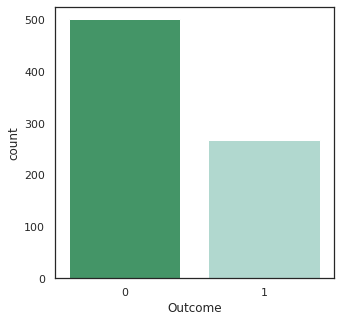

In [58]:
#Using the value_counts to see the distribution of the class variable
print(pima_df['Outcome'].value_counts())
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("white")
sns.countplot(pima_df['Outcome'], palette='BuGn_r')

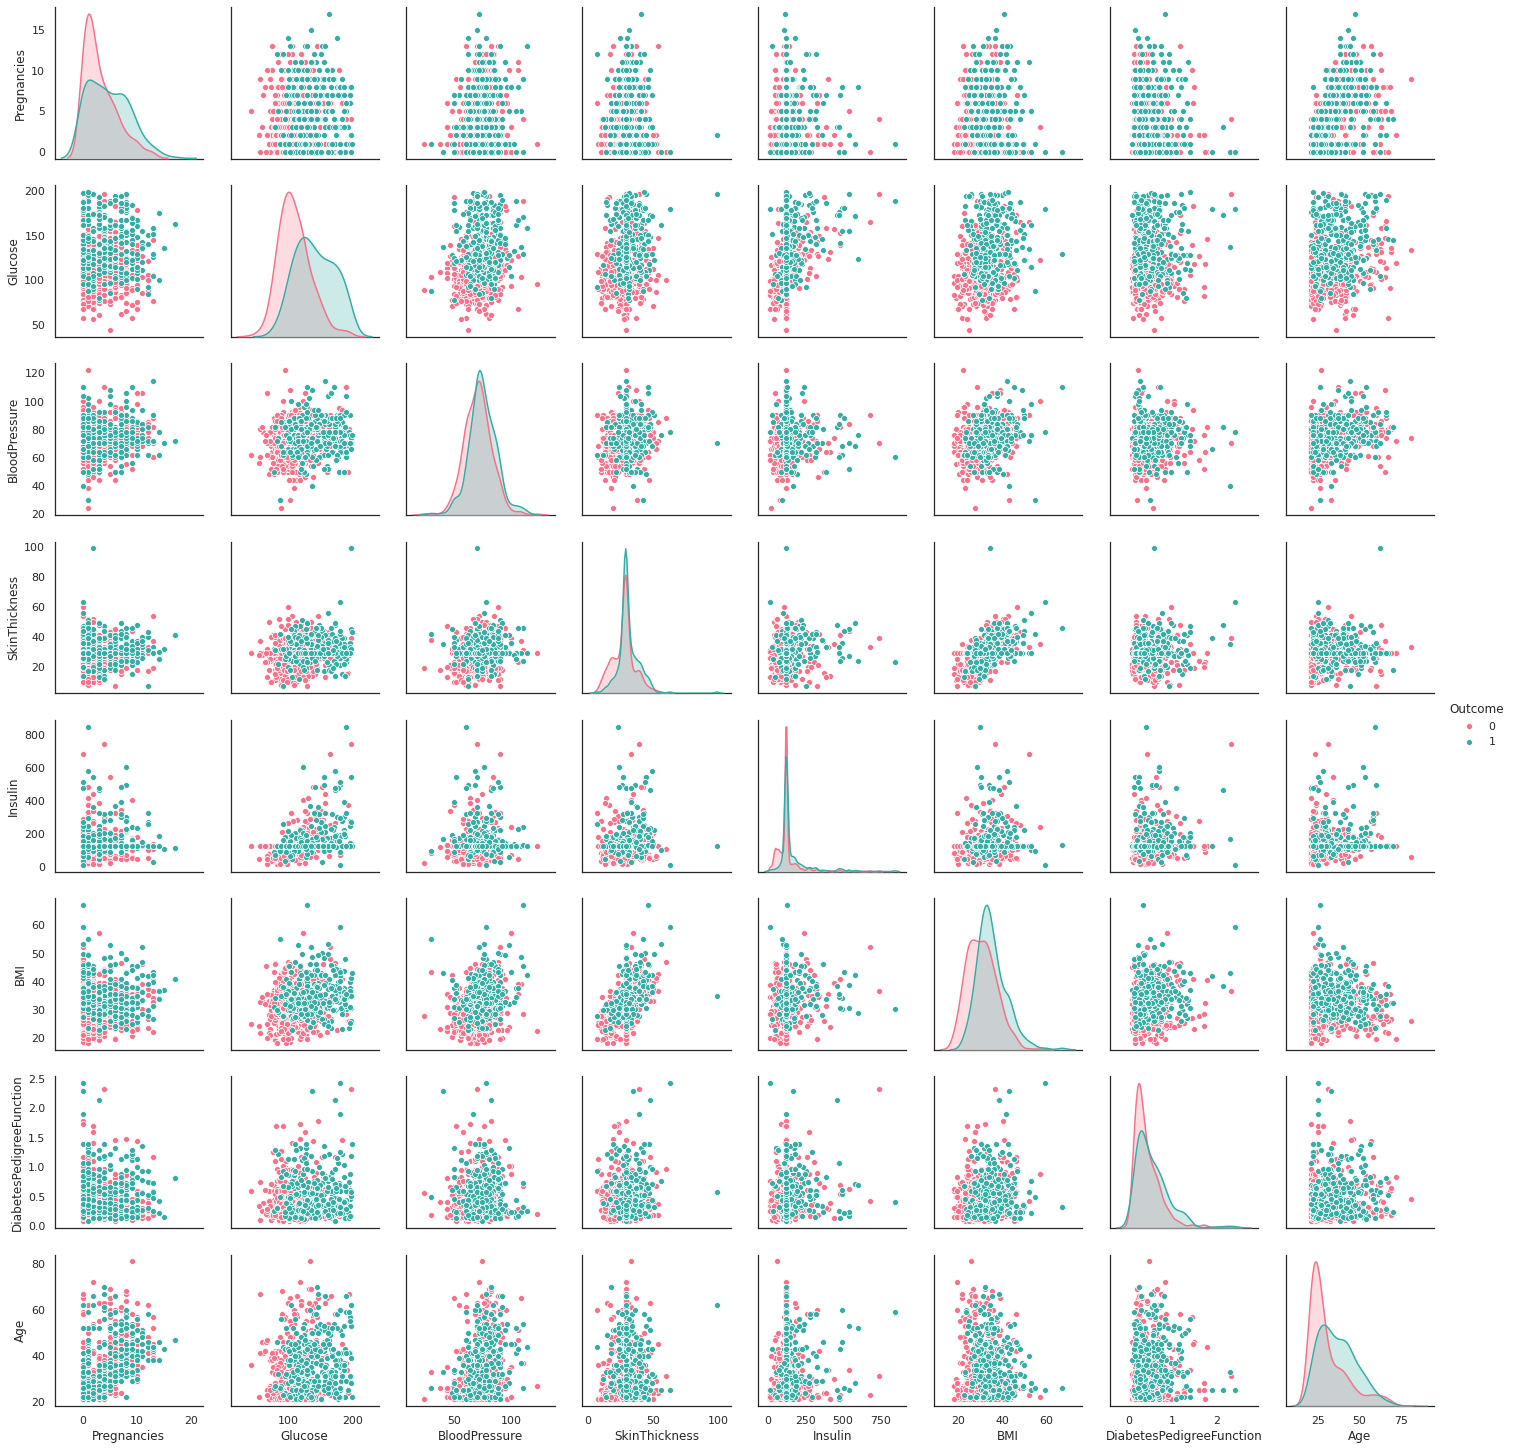

In [59]:
#Plotting pair plot for all variables
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style("white")
sns.pairplot(pima_df, hue="Outcome", palette='husl')

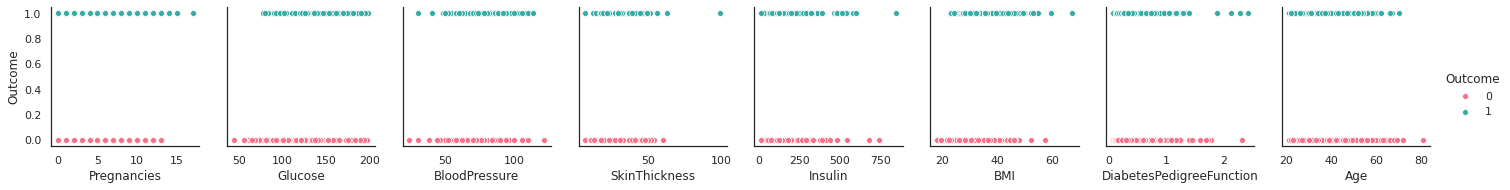

In [60]:
#Plotting only between the target and independent variables
sns.pairplot(pima_df, x_vars = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'],
             y_vars = ['Outcome'], palette="husl", hue = 'Outcome')

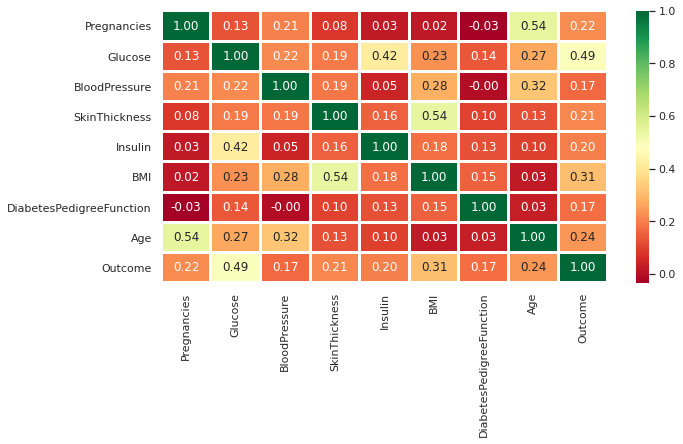

In [61]:
#Plotting the correlation matrix using sns.heatmap()
plt.figure(figsize = (10,5))
sns.set(font_scale=1.0)
sns.heatmap(pima_df.corr(),annot = True, fmt = '.2f', cmap="RdYlGn",
             linecolor='white', linewidths= '2', cbar = True )

Insights:¶
Glucose and the Outcome has the highest correlation of 0.49.
Other variables tend to be weakly correlated.
BMI and SkinThickness seem to be slightly correlated (0.54).
Pregnancies and Age also seem to be slightly correlated (0.54).
None of the individual features seem to have a high correlation with our target variable 'Outcome'!

In [62]:
#Separating the target variable from the features
X = pima_df.iloc[:, 0:8]
y= pima_df['Outcome']

In [63]:
# Splitting the dataset into train and test set with a 70:30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 7)

In [64]:
y_test.shape

(231,)

In [65]:
# Normalising the X variables
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform (X_test)

In [66]:
# One hot encoding the Y variable
ohe = OneHotEncoder(sparse=False)
y_train_ohe = ohe.fit_transform(pd.DataFrame(y_train))
y_test_ohe = ohe.fit_transform(pd.DataFrame(y_test))

In [67]:
y_test_ohe.shape

(231, 2)

In [68]:
# Defining x_val and y_val for Talos scan
x_val = X_test_scaled.copy()
y_val = y_test_ohe.copy()

In [74]:
# Creating the list of parameters
p = {'activation1':[tanh],
     'activation2':[tanh],
     'final_activation': [softmax],
     'optimizer': ['Adam', "RMSprop"],
     'losses': [categorical_crossentropy],
     'first_hidden_layer': [16,24],
     'second_hidden_layer': [16,24],
     'batch_size': [20,40],
     'epochs': [10,20,30]}

In [103]:

def diabetes_model(X_train_scaled, y_train_ohe, X_test_scaled, y_test_ohe, params):
    model = Sequential()
    model.add(Dense(params['first_hidden_layer'], 
                    input_shape=(8,), 
                    activation=params['activation1'], 
                    use_bias=True))
    model.add(Dropout(0.3))
    model.add(Dense(params['second_hidden_layer'], 
                    activation=params['activation2'], 
                    use_bias=True))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation=params['final_activation']))

    model.compile(optimizer=params['optimizer'], 
                  loss=params['losses'], 
                  metrics=[tf.keras.metrics.binary_accuracy])
    history = model.fit(X_train_scaled, 
                    y_train_ohe,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopper(epochs=params['epochs'], 
                                                    mode='moderate', 
                                                    monitor='val_loss')])
    return history, model



In [105]:
h = Scan(X_train_scaled, 
         y_train_ohe, 
         model=diabetes_model, 
         params=p,
         reduction_metric =None, 
         print_params=True,         
         experiment_name= 'Diabetes_ANN_Hyp_Autotuning',
         x_val = X_test_scaled,
         y_val = y_test_ohe)



  0%|          | 0/48 [00:00<?, ?it/s]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/10
27/27 [==============================] - 0s 7ms/step - loss: 0.7092 - binary_accuracy: 0.4823 - val_loss: 0.6621 - val_binary_accuracy: 0.6234
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6541 - binary_accuracy: 0.6611 - val_loss: 0.6509 - val_binary_accuracy: 0.6364
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6483 - binary_accuracy: 0.6574 - val_loss: 0.6477 - val_binary_accuracy: 0.6364
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6637 - binary_accuracy: 0.6425 - val_loss: 0.6412 - val_binary_accuracy: 0.6364
Epoch 5/10
27/27 [==============================] - 0s



  2%|▏         | 1/48 [00:01<01:14,  1.59s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/10
27/27 [==============================] - 0s 7ms/step - loss: 0.6974 - binary_accuracy: 0.5512 - val_loss: 0.6502 - val_binary_accuracy: 0.6364
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6562 - binary_accuracy: 0.6331 - val_loss: 0.6438 - val_binary_accuracy: 0.6364
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6488 - binary_accuracy: 0.6592 - val_loss: 0.6287 - val_binary_accuracy: 0.6364
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6299 - binary_accuracy: 0.6685 - val_loss: 0.6186 - val_binary_accuracy: 0.6364
Epoch 5/10
27/27 [==============================] - 0s



  4%|▍         | 2/48 [00:03<01:12,  1.57s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/10
27/27 [==============================] - 0s 8ms/step - loss: 0.6727 - binary_accuracy: 0.6182 - val_loss: 0.6498 - val_binary_accuracy: 0.6320
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6596 - binary_accuracy: 0.6238 - val_loss: 0.6407 - val_binary_accuracy: 0.6320
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6417 - binary_accuracy: 0.6629 - val_loss: 0.6314 - val_binary_accuracy: 0.6320
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6478 - binary_accuracy: 0.6704 - val_loss: 0.6222 - val_binary_accuracy: 0.6537
Epoch 5/10
27/27 [==============================] -



  6%|▋         | 3/48 [00:04<01:11,  1.60s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/10
27/27 [==============================] - 0s 8ms/step - loss: 0.7013 - binary_accuracy: 0.5773 - val_loss: 0.6803 - val_binary_accuracy: 0.6190
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6791 - binary_accuracy: 0.6369 - val_loss: 0.6642 - val_binary_accuracy: 0.6320
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6662 - binary_accuracy: 0.6536 - val_loss: 0.6508 - val_binary_accuracy: 0.6320
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6499 - binary_accuracy: 0.6704 - val_loss: 0.6375 - val_binary_accuracy: 0.6364
Epoch 5/10
27/27 [==============================] -



  8%|▊         | 4/48 [00:06<01:12,  1.64s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/10
27/27 [==============================] - 0s 7ms/step - loss: 0.7344 - binary_accuracy: 0.4674 - val_loss: 0.6574 - val_binary_accuracy: 0.6407
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6776 - binary_accuracy: 0.6387 - val_loss: 0.6454 - val_binary_accuracy: 0.6364
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6341 - binary_accuracy: 0.6704 - val_loss: 0.6361 - val_binary_accuracy: 0.6364
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6442 - binary_accuracy: 0.6797 - val_loss: 0.6224 - val_binary_accuracy: 0.6494
Epoch 5/10
27/27 [==============================] - 0s



 10%|█         | 5/48 [00:08<01:09,  1.62s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/10
27/27 [==============================] - 0s 8ms/step - loss: 0.7091 - binary_accuracy: 0.5587 - val_loss: 0.6652 - val_binary_accuracy: 0.6364
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 0.6726 - binary_accuracy: 0.6555 - val_loss: 0.6489 - val_binary_accuracy: 0.6407
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6395 - binary_accuracy: 0.6667 - val_loss: 0.6332 - val_binary_accuracy: 0.6407
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 0.6453 - binary_accuracy: 0.6629 - val_loss: 0.6172 - val_binary_accuracy: 0.6450
Epoch 5/10
27/27 [==============================] - 0s



 12%|█▎        | 6/48 [00:09<01:10,  1.67s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/10
27/27 [==============================] - 0s 9ms/step - loss: 0.7088 - binary_accuracy: 0.5959 - val_loss: 0.6826 - val_binary_accuracy: 0.6364
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 0.7016 - binary_accuracy: 0.6052 - val_loss: 0.6638 - val_binary_accuracy: 0.6364
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6601 - binary_accuracy: 0.6425 - val_loss: 0.6460 - val_binary_accuracy: 0.6364
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6564 - binary_accuracy: 0.6462 - val_loss: 0.6308 - val_binary_accuracy: 0.6450
Epoch 5/10
27/27 [==============================] -



 15%|█▍        | 7/48 [00:11<01:11,  1.73s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/10
27/27 [==============================] - 0s 7ms/step - loss: 0.7178 - binary_accuracy: 0.5345 - val_loss: 0.6611 - val_binary_accuracy: 0.6364
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6789 - binary_accuracy: 0.6257 - val_loss: 0.6483 - val_binary_accuracy: 0.6364
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6661 - binary_accuracy: 0.6331 - val_loss: 0.6394 - val_binary_accuracy: 0.6364
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 0.6345 - binary_accuracy: 0.6629 - val_loss: 0.6226 - val_binary_accuracy: 0.6450
Epoch 5/10
27/27 [==============================] -



 17%|█▋        | 8/48 [00:13<01:09,  1.73s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/20
27/27 [==============================] - 0s 7ms/step - loss: 0.6840 - binary_accuracy: 0.6276 - val_loss: 0.6548 - val_binary_accuracy: 0.6407
Epoch 2/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6608 - binary_accuracy: 0.6518 - val_loss: 0.6441 - val_binary_accuracy: 0.6407
Epoch 3/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6472 - binary_accuracy: 0.6555 - val_loss: 0.6289 - val_binary_accuracy: 0.6450
Epoch 4/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6316 - binary_accuracy: 0.6685 - val_loss: 0.6165 - val_binary_accuracy: 0.6450
Epoch 5/20
27/27 [==============================] - 0s



 19%|█▉        | 9/48 [00:15<01:12,  1.87s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/20
27/27 [==============================] - 0s 7ms/step - loss: 0.6941 - binary_accuracy: 0.5270 - val_loss: 0.6513 - val_binary_accuracy: 0.6407
Epoch 2/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6496 - binary_accuracy: 0.6387 - val_loss: 0.6404 - val_binary_accuracy: 0.6364
Epoch 3/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6417 - binary_accuracy: 0.6518 - val_loss: 0.6311 - val_binary_accuracy: 0.6364
Epoch 4/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6267 - binary_accuracy: 0.6797 - val_loss: 0.6191 - val_binary_accuracy: 0.6494
Epoch 5/20
27/27 [==============================] - 0s



 21%|██        | 10/48 [00:17<01:15,  1.99s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/20
27/27 [==============================] - 0s 7ms/step - loss: 0.7384 - binary_accuracy: 0.5196 - val_loss: 0.6576 - val_binary_accuracy: 0.6407
Epoch 2/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6658 - binary_accuracy: 0.6220 - val_loss: 0.6437 - val_binary_accuracy: 0.6364
Epoch 3/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6559 - binary_accuracy: 0.6313 - val_loss: 0.6368 - val_binary_accuracy: 0.6364
Epoch 4/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6368 - binary_accuracy: 0.6592 - val_loss: 0.6265 - val_binary_accuracy: 0.6364
Epoch 5/20
27/27 [==============================] -



 23%|██▎       | 11/48 [00:20<01:16,  2.08s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/20
27/27 [==============================] - 0s 8ms/step - loss: 0.6890 - binary_accuracy: 0.6052 - val_loss: 0.6649 - val_binary_accuracy: 0.6364
Epoch 2/20
27/27 [==============================] - 0s 3ms/step - loss: 0.6764 - binary_accuracy: 0.6313 - val_loss: 0.6541 - val_binary_accuracy: 0.6364
Epoch 3/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6396 - binary_accuracy: 0.6760 - val_loss: 0.6400 - val_binary_accuracy: 0.6320
Epoch 4/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6527 - binary_accuracy: 0.6592 - val_loss: 0.6281 - val_binary_accuracy: 0.6364
Epoch 5/20
27/27 [==============================] -



 25%|██▌       | 12/48 [00:22<01:18,  2.19s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/20
27/27 [==============================] - 0s 7ms/step - loss: 0.7091 - binary_accuracy: 0.5084 - val_loss: 0.6644 - val_binary_accuracy: 0.6364
Epoch 2/20
27/27 [==============================] - 0s 3ms/step - loss: 0.6665 - binary_accuracy: 0.6369 - val_loss: 0.6546 - val_binary_accuracy: 0.6364
Epoch 3/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6568 - binary_accuracy: 0.6574 - val_loss: 0.6389 - val_binary_accuracy: 0.6320
Epoch 4/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6546 - binary_accuracy: 0.6536 - val_loss: 0.6268 - val_binary_accuracy: 0.6364
Epoch 5/20
27/27 [==============================] - 0s



 27%|██▋       | 13/48 [00:25<01:26,  2.49s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/20
27/27 [==============================] - 0s 13ms/step - loss: 0.6823 - binary_accuracy: 0.6071 - val_loss: 0.6363 - val_binary_accuracy: 0.6450
Epoch 2/20
27/27 [==============================] - 0s 4ms/step - loss: 0.6545 - binary_accuracy: 0.6518 - val_loss: 0.6204 - val_binary_accuracy: 0.6667
Epoch 3/20
27/27 [==============================] - 0s 4ms/step - loss: 0.6351 - binary_accuracy: 0.6685 - val_loss: 0.6048 - val_binary_accuracy: 0.6667
Epoch 4/20
27/27 [==============================] - 0s 3ms/step - loss: 0.6071 - binary_accuracy: 0.7076 - val_loss: 0.5905 - val_binary_accuracy: 0.6667
Epoch 5/20
27/27 [==============================] - 0



 29%|██▉       | 14/48 [00:29<01:35,  2.82s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/20
27/27 [==============================] - 0s 11ms/step - loss: 0.7014 - binary_accuracy: 0.6127 - val_loss: 0.6898 - val_binary_accuracy: 0.6364
Epoch 2/20
27/27 [==============================] - 0s 3ms/step - loss: 0.6892 - binary_accuracy: 0.6406 - val_loss: 0.6724 - val_binary_accuracy: 0.6364
Epoch 3/20
27/27 [==============================] - 0s 3ms/step - loss: 0.6591 - binary_accuracy: 0.6574 - val_loss: 0.6600 - val_binary_accuracy: 0.6364
Epoch 4/20
27/27 [==============================] - 0s 4ms/step - loss: 0.6632 - binary_accuracy: 0.6574 - val_loss: 0.6432 - val_binary_accuracy: 0.6364
Epoch 5/20
27/27 [==============================] 



 31%|███▏      | 15/48 [00:33<01:40,  3.04s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/20
27/27 [==============================] - 0s 11ms/step - loss: 0.7006 - binary_accuracy: 0.5661 - val_loss: 0.6494 - val_binary_accuracy: 0.6364
Epoch 2/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6476 - binary_accuracy: 0.6667 - val_loss: 0.6393 - val_binary_accuracy: 0.6364
Epoch 3/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6339 - binary_accuracy: 0.6648 - val_loss: 0.6270 - val_binary_accuracy: 0.6407
Epoch 4/20
27/27 [==============================] - 0s 2ms/step - loss: 0.6256 - binary_accuracy: 0.6741 - val_loss: 0.6177 - val_binary_accuracy: 0.6407
Epoch 5/20
27/27 [==============================] 



 33%|███▎      | 16/48 [00:35<01:34,  2.97s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/30
27/27 [==============================] - 0s 8ms/step - loss: 0.7272 - binary_accuracy: 0.5531 - val_loss: 0.6834 - val_binary_accuracy: 0.6364
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6949 - binary_accuracy: 0.6127 - val_loss: 0.6725 - val_binary_accuracy: 0.6364
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6735 - binary_accuracy: 0.6369 - val_loss: 0.6608 - val_binary_accuracy: 0.6364
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6605 - binary_accuracy: 0.6536 - val_loss: 0.6492 - val_binary_accuracy: 0.6364
Epoch 5/30
27/27 [==============================] - 0s



 35%|███▌      | 17/48 [00:38<01:31,  2.96s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/30
27/27 [==============================] - 0s 7ms/step - loss: 0.6488 - binary_accuracy: 0.6257 - val_loss: 0.6330 - val_binary_accuracy: 0.6320
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6628 - binary_accuracy: 0.6313 - val_loss: 0.6184 - val_binary_accuracy: 0.6450
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6470 - binary_accuracy: 0.6555 - val_loss: 0.6081 - val_binary_accuracy: 0.6623
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6157 - binary_accuracy: 0.6983 - val_loss: 0.5975 - val_binary_accuracy: 0.6710
Epoch 5/30
27/27 [==============================] - 0s



 38%|███▊      | 18/48 [00:41<01:28,  2.93s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/30
27/27 [==============================] - 0s 7ms/step - loss: 0.6855 - binary_accuracy: 0.5903 - val_loss: 0.6558 - val_binary_accuracy: 0.6364
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6494 - binary_accuracy: 0.6555 - val_loss: 0.6477 - val_binary_accuracy: 0.6364
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6581 - binary_accuracy: 0.6480 - val_loss: 0.6384 - val_binary_accuracy: 0.6364
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6353 - binary_accuracy: 0.6574 - val_loss: 0.6289 - val_binary_accuracy: 0.6407
Epoch 5/30
27/27 [==============================] -



 40%|███▉      | 19/48 [00:44<01:27,  3.01s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/30
27/27 [==============================] - 0s 8ms/step - loss: 0.6961 - binary_accuracy: 0.6220 - val_loss: 0.6618 - val_binary_accuracy: 0.6364
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6764 - binary_accuracy: 0.6462 - val_loss: 0.6464 - val_binary_accuracy: 0.6364
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6560 - binary_accuracy: 0.6667 - val_loss: 0.6334 - val_binary_accuracy: 0.6407
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6283 - binary_accuracy: 0.6816 - val_loss: 0.6217 - val_binary_accuracy: 0.6450
Epoch 5/30
27/27 [==============================] -



 42%|████▏     | 20/48 [00:47<01:25,  3.04s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/30
27/27 [==============================] - 0s 8ms/step - loss: 0.7318 - binary_accuracy: 0.5475 - val_loss: 0.6722 - val_binary_accuracy: 0.6190
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6873 - binary_accuracy: 0.6164 - val_loss: 0.6531 - val_binary_accuracy: 0.6364
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6473 - binary_accuracy: 0.6574 - val_loss: 0.6312 - val_binary_accuracy: 0.6147
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6436 - binary_accuracy: 0.6611 - val_loss: 0.6138 - val_binary_accuracy: 0.6450
Epoch 5/30
27/27 [==============================] - 0s



 44%|████▍     | 21/48 [00:50<01:20,  2.99s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/30
27/27 [==============================] - 0s 7ms/step - loss: 0.7219 - binary_accuracy: 0.5903 - val_loss: 0.6731 - val_binary_accuracy: 0.6320
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.7246 - binary_accuracy: 0.5773 - val_loss: 0.6539 - val_binary_accuracy: 0.6364
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6865 - binary_accuracy: 0.6257 - val_loss: 0.6387 - val_binary_accuracy: 0.6364
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6262 - binary_accuracy: 0.6983 - val_loss: 0.6204 - val_binary_accuracy: 0.6494
Epoch 5/30
27/27 [==============================] - 0s



 46%|████▌     | 22/48 [00:53<01:18,  3.02s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/30
27/27 [==============================] - 0s 7ms/step - loss: 0.6844 - binary_accuracy: 0.5847 - val_loss: 0.6709 - val_binary_accuracy: 0.6364
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6592 - binary_accuracy: 0.6480 - val_loss: 0.6553 - val_binary_accuracy: 0.6364
Epoch 3/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6441 - binary_accuracy: 0.6555 - val_loss: 0.6418 - val_binary_accuracy: 0.6364
Epoch 4/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6402 - binary_accuracy: 0.6629 - val_loss: 0.6298 - val_binary_accuracy: 0.6364
Epoch 5/30
27/27 [==============================] -



 48%|████▊     | 23/48 [00:56<01:15,  3.02s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 20, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/30
27/27 [==============================] - 0s 8ms/step - loss: 0.6742 - binary_accuracy: 0.6071 - val_loss: 0.6400 - val_binary_accuracy: 0.6364
Epoch 2/30
27/27 [==============================] - 0s 2ms/step - loss: 0.6593 - binary_accuracy: 0.6555 - val_loss: 0.6242 - val_binary_accuracy: 0.6320
Epoch 3/30
27/27 [==============================] - 0s 3ms/step - loss: 0.6344 - binary_accuracy: 0.6629 - val_loss: 0.6118 - val_binary_accuracy: 0.6797
Epoch 4/30
27/27 [==============================] - 0s 3ms/step - loss: 0.6317 - binary_accuracy: 0.6723 - val_loss: 0.5997 - val_binary_accuracy: 0.6797
Epoch 5/30
27/27 [==============================] -



 50%|█████     | 24/48 [01:00<01:13,  3.06s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/10
14/14 [==============================] - 0s 13ms/step - loss: 0.6882 - binary_accuracy: 0.6387 - val_loss: 0.6814 - val_binary_accuracy: 0.6364
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6842 - binary_accuracy: 0.6331 - val_loss: 0.6731 - val_binary_accuracy: 0.6364
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6766 - binary_accuracy: 0.6350 - val_loss: 0.6678 - val_binary_accuracy: 0.6364
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6676 - binary_accuracy: 0.6499 - val_loss: 0.6623 - val_binary_accuracy: 0.6364
Epoch 5/10
14/14 [==============================] - 0



 52%|█████▏    | 25/48 [01:01<00:59,  2.57s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/10
14/14 [==============================] - 0s 12ms/step - loss: 0.6894 - binary_accuracy: 0.5810 - val_loss: 0.6794 - val_binary_accuracy: 0.6407
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6786 - binary_accuracy: 0.6276 - val_loss: 0.6681 - val_binary_accuracy: 0.6320
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6706 - binary_accuracy: 0.6313 - val_loss: 0.6566 - val_binary_accuracy: 0.6320
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6598 - binary_accuracy: 0.6592 - val_loss: 0.6456 - val_binary_accuracy: 0.6277
Epoch 5/10
14/14 [==============================] - 0



 54%|█████▍    | 26/48 [01:02<00:48,  2.21s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/10
14/14 [==============================] - 0s 12ms/step - loss: 0.7114 - binary_accuracy: 0.6480 - val_loss: 0.6834 - val_binary_accuracy: 0.6364
Epoch 2/10
14/14 [==============================] - 0s 4ms/step - loss: 0.6884 - binary_accuracy: 0.6369 - val_loss: 0.6660 - val_binary_accuracy: 0.6320
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6640 - binary_accuracy: 0.6089 - val_loss: 0.6568 - val_binary_accuracy: 0.6320
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6628 - binary_accuracy: 0.6443 - val_loss: 0.6447 - val_binary_accuracy: 0.6407
Epoch 5/10
14/14 [==============================] 



 56%|█████▋    | 27/48 [01:04<00:42,  2.00s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/10
14/14 [==============================] - 0s 12ms/step - loss: 0.6688 - binary_accuracy: 0.6276 - val_loss: 0.6639 - val_binary_accuracy: 0.6364
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6635 - binary_accuracy: 0.6536 - val_loss: 0.6553 - val_binary_accuracy: 0.6364
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6565 - binary_accuracy: 0.6611 - val_loss: 0.6438 - val_binary_accuracy: 0.6364
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6473 - binary_accuracy: 0.6592 - val_loss: 0.6334 - val_binary_accuracy: 0.6320
Epoch 5/10
14/14 [==============================] 



 58%|█████▊    | 28/48 [01:05<00:37,  1.87s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/10
14/14 [==============================] - 0s 12ms/step - loss: 0.7104 - binary_accuracy: 0.5251 - val_loss: 0.6729 - val_binary_accuracy: 0.6364
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6834 - binary_accuracy: 0.6425 - val_loss: 0.6677 - val_binary_accuracy: 0.6364
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6921 - binary_accuracy: 0.6220 - val_loss: 0.6561 - val_binary_accuracy: 0.6364
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6563 - binary_accuracy: 0.6592 - val_loss: 0.6458 - val_binary_accuracy: 0.6364
Epoch 5/10
14/14 [==============================] - 0



 60%|██████    | 29/48 [01:07<00:32,  1.72s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/10
14/14 [==============================] - 0s 12ms/step - loss: 0.7328 - binary_accuracy: 0.4730 - val_loss: 0.6804 - val_binary_accuracy: 0.6147
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6813 - binary_accuracy: 0.6220 - val_loss: 0.6728 - val_binary_accuracy: 0.6320
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6658 - binary_accuracy: 0.6369 - val_loss: 0.6589 - val_binary_accuracy: 0.6320
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6588 - binary_accuracy: 0.6443 - val_loss: 0.6466 - val_binary_accuracy: 0.6407
Epoch 5/10
14/14 [==============================] - 0



 62%|██████▎   | 30/48 [01:08<00:29,  1.62s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/10
14/14 [==============================] - 0s 13ms/step - loss: 0.7493 - binary_accuracy: 0.4507 - val_loss: 0.6744 - val_binary_accuracy: 0.6147
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6721 - binary_accuracy: 0.6331 - val_loss: 0.6614 - val_binary_accuracy: 0.6364
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6673 - binary_accuracy: 0.6294 - val_loss: 0.6510 - val_binary_accuracy: 0.6364
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6741 - binary_accuracy: 0.6425 - val_loss: 0.6392 - val_binary_accuracy: 0.6364
Epoch 5/10
14/14 [==============================] 



 65%|██████▍   | 31/48 [01:10<00:27,  1.59s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 10, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/10
14/14 [==============================] - 0s 13ms/step - loss: 0.6945 - binary_accuracy: 0.5512 - val_loss: 0.6639 - val_binary_accuracy: 0.6364
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6857 - binary_accuracy: 0.6294 - val_loss: 0.6535 - val_binary_accuracy: 0.6364
Epoch 3/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6607 - binary_accuracy: 0.6331 - val_loss: 0.6441 - val_binary_accuracy: 0.6364
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.6614 - binary_accuracy: 0.6350 - val_loss: 0.6333 - val_binary_accuracy: 0.6320
Epoch 5/10
14/14 [==============================] 



 67%|██████▋   | 32/48 [01:11<00:25,  1.59s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/20
14/14 [==============================] - 0s 12ms/step - loss: 0.7019 - binary_accuracy: 0.5493 - val_loss: 0.6596 - val_binary_accuracy: 0.6364
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6538 - binary_accuracy: 0.6443 - val_loss: 0.6517 - val_binary_accuracy: 0.6364
Epoch 3/20
14/14 [==============================] - 0s 2ms/step - loss: 0.6731 - binary_accuracy: 0.6369 - val_loss: 0.6484 - val_binary_accuracy: 0.6364
Epoch 4/20
14/14 [==============================] - 0s 2ms/step - loss: 0.6540 - binary_accuracy: 0.6276 - val_loss: 0.6410 - val_binary_accuracy: 0.6364
Epoch 5/20
14/14 [==============================] - 0



 69%|██████▉   | 33/48 [01:13<00:25,  1.67s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/20
14/14 [==============================] - 0s 12ms/step - loss: 0.6889 - binary_accuracy: 0.5847 - val_loss: 0.6683 - val_binary_accuracy: 0.6364
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6665 - binary_accuracy: 0.6369 - val_loss: 0.6589 - val_binary_accuracy: 0.6364
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6539 - binary_accuracy: 0.6387 - val_loss: 0.6505 - val_binary_accuracy: 0.6364
Epoch 4/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6524 - binary_accuracy: 0.6555 - val_loss: 0.6432 - val_binary_accuracy: 0.6364
Epoch 5/20
14/14 [==============================] - 0



 71%|███████   | 34/48 [01:15<00:24,  1.75s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/20
14/14 [==============================] - 0s 13ms/step - loss: 0.7303 - binary_accuracy: 0.5642 - val_loss: 0.7080 - val_binary_accuracy: 0.6364
Epoch 2/20
14/14 [==============================] - 0s 4ms/step - loss: 0.7090 - binary_accuracy: 0.6071 - val_loss: 0.6908 - val_binary_accuracy: 0.6364
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6805 - binary_accuracy: 0.6387 - val_loss: 0.6784 - val_binary_accuracy: 0.6364
Epoch 4/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6602 - binary_accuracy: 0.6629 - val_loss: 0.6668 - val_binary_accuracy: 0.6364
Epoch 5/20
14/14 [==============================] 



 73%|███████▎  | 35/48 [01:17<00:24,  1.90s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/20
14/14 [==============================] - 0s 15ms/step - loss: 0.6940 - binary_accuracy: 0.5661 - val_loss: 0.6552 - val_binary_accuracy: 0.6364
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6651 - binary_accuracy: 0.6406 - val_loss: 0.6455 - val_binary_accuracy: 0.6364
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6529 - binary_accuracy: 0.6406 - val_loss: 0.6367 - val_binary_accuracy: 0.6364
Epoch 4/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6557 - binary_accuracy: 0.6164 - val_loss: 0.6309 - val_binary_accuracy: 0.6364
Epoch 5/20
14/14 [==============================] 



 75%|███████▌  | 36/48 [01:20<00:23,  1.99s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/20
14/14 [==============================] - 0s 13ms/step - loss: 0.7096 - binary_accuracy: 0.5345 - val_loss: 0.6784 - val_binary_accuracy: 0.6364
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6795 - binary_accuracy: 0.6313 - val_loss: 0.6751 - val_binary_accuracy: 0.6364
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6731 - binary_accuracy: 0.6574 - val_loss: 0.6655 - val_binary_accuracy: 0.6364
Epoch 4/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6700 - binary_accuracy: 0.6369 - val_loss: 0.6586 - val_binary_accuracy: 0.6364
Epoch 5/20
14/14 [==============================] - 0



 77%|███████▋  | 37/48 [01:21<00:21,  1.93s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/20
14/14 [==============================] - 0s 12ms/step - loss: 0.7312 - binary_accuracy: 0.4823 - val_loss: 0.6739 - val_binary_accuracy: 0.6364
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6691 - binary_accuracy: 0.6406 - val_loss: 0.6665 - val_binary_accuracy: 0.6364
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6703 - binary_accuracy: 0.6518 - val_loss: 0.6572 - val_binary_accuracy: 0.6364
Epoch 4/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6669 - binary_accuracy: 0.6425 - val_loss: 0.6477 - val_binary_accuracy: 0.6364
Epoch 5/20
14/14 [==============================] - 0



 79%|███████▉  | 38/48 [01:23<00:19,  1.92s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/20
14/14 [==============================] - 0s 14ms/step - loss: 0.6819 - binary_accuracy: 0.5903 - val_loss: 0.6583 - val_binary_accuracy: 0.6320
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6697 - binary_accuracy: 0.6313 - val_loss: 0.6478 - val_binary_accuracy: 0.6320
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6485 - binary_accuracy: 0.6592 - val_loss: 0.6390 - val_binary_accuracy: 0.6364
Epoch 4/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6400 - binary_accuracy: 0.6778 - val_loss: 0.6331 - val_binary_accuracy: 0.6364
Epoch 5/20
14/14 [==============================] 



 81%|████████▏ | 39/48 [01:25<00:17,  1.97s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 20, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/20
14/14 [==============================] - 0s 12ms/step - loss: 0.7251 - binary_accuracy: 0.6182 - val_loss: 0.6832 - val_binary_accuracy: 0.6364
Epoch 2/20
14/14 [==============================] - 0s 3ms/step - loss: 0.7003 - binary_accuracy: 0.6052 - val_loss: 0.6707 - val_binary_accuracy: 0.6364
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6819 - binary_accuracy: 0.6313 - val_loss: 0.6570 - val_binary_accuracy: 0.6364
Epoch 4/20
14/14 [==============================] - 0s 3ms/step - loss: 0.6671 - binary_accuracy: 0.6592 - val_loss: 0.6439 - val_binary_accuracy: 0.6364
Epoch 5/20
14/14 [==============================] 



 83%|████████▎ | 40/48 [01:27<00:15,  1.99s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/30
14/14 [==============================] - 0s 11ms/step - loss: 0.8235 - binary_accuracy: 0.3762 - val_loss: 0.7293 - val_binary_accuracy: 0.3853
Epoch 2/30
14/14 [==============================] - 0s 2ms/step - loss: 0.7175 - binary_accuracy: 0.5065 - val_loss: 0.6600 - val_binary_accuracy: 0.6753
Epoch 3/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6600 - binary_accuracy: 0.6313 - val_loss: 0.6421 - val_binary_accuracy: 0.6364
Epoch 4/30
14/14 [==============================] - 0s 2ms/step - loss: 0.6572 - binary_accuracy: 0.6369 - val_loss: 0.6384 - val_binary_accuracy: 0.6407
Epoch 5/30
14/14 [==============================] - 0



 85%|████████▌ | 41/48 [01:30<00:14,  2.09s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/30
14/14 [==============================] - 0s 12ms/step - loss: 0.7784 - binary_accuracy: 0.4022 - val_loss: 0.6925 - val_binary_accuracy: 0.5368
Epoch 2/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6892 - binary_accuracy: 0.5810 - val_loss: 0.6595 - val_binary_accuracy: 0.6407
Epoch 3/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6555 - binary_accuracy: 0.6685 - val_loss: 0.6551 - val_binary_accuracy: 0.6364
Epoch 4/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6600 - binary_accuracy: 0.6667 - val_loss: 0.6444 - val_binary_accuracy: 0.6407
Epoch 5/30
14/14 [==============================] - 0



 88%|████████▊ | 42/48 [01:32<00:13,  2.19s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/30
14/14 [==============================] - 0s 13ms/step - loss: 0.6943 - binary_accuracy: 0.5698 - val_loss: 0.6807 - val_binary_accuracy: 0.6364
Epoch 2/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6963 - binary_accuracy: 0.6089 - val_loss: 0.6726 - val_binary_accuracy: 0.6364
Epoch 3/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6668 - binary_accuracy: 0.6555 - val_loss: 0.6662 - val_binary_accuracy: 0.6364
Epoch 4/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6787 - binary_accuracy: 0.6387 - val_loss: 0.6603 - val_binary_accuracy: 0.6364
Epoch 5/30
14/14 [==============================] 



 90%|████████▉ | 43/48 [01:35<00:11,  2.34s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 16, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/30
14/14 [==============================] - 0s 16ms/step - loss: 0.7117 - binary_accuracy: 0.5251 - val_loss: 0.6891 - val_binary_accuracy: 0.6407
Epoch 2/30
14/14 [==============================] - 0s 4ms/step - loss: 0.6917 - binary_accuracy: 0.6387 - val_loss: 0.6733 - val_binary_accuracy: 0.6364
Epoch 3/30
14/14 [==============================] - 0s 4ms/step - loss: 0.6703 - binary_accuracy: 0.6387 - val_loss: 0.6624 - val_binary_accuracy: 0.6364
Epoch 4/30
14/14 [==============================] - 0s 4ms/step - loss: 0.6547 - binary_accuracy: 0.6499 - val_loss: 0.6509 - val_binary_accuracy: 0.6364
Epoch 5/30
14/14 [==============================] 



 92%|█████████▏| 44/48 [01:38<00:09,  2.50s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 16}
Epoch 1/30
14/14 [==============================] - 0s 13ms/step - loss: 0.6696 - binary_accuracy: 0.6220 - val_loss: 0.6571 - val_binary_accuracy: 0.6364
Epoch 2/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6644 - binary_accuracy: 0.6164 - val_loss: 0.6476 - val_binary_accuracy: 0.6364
Epoch 3/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6434 - binary_accuracy: 0.6555 - val_loss: 0.6395 - val_binary_accuracy: 0.6364
Epoch 4/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6440 - binary_accuracy: 0.6499 - val_loss: 0.6297 - val_binary_accuracy: 0.6364
Epoch 5/30
14/14 [==============================] - 0



 94%|█████████▍| 45/48 [01:40<00:07,  2.47s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'Adam', 'second_hidden_layer': 24}
Epoch 1/30
14/14 [==============================] - 0s 12ms/step - loss: 0.6865 - binary_accuracy: 0.6034 - val_loss: 0.6508 - val_binary_accuracy: 0.6450
Epoch 2/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6624 - binary_accuracy: 0.6406 - val_loss: 0.6420 - val_binary_accuracy: 0.6494
Epoch 3/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6669 - binary_accuracy: 0.6462 - val_loss: 0.6332 - val_binary_accuracy: 0.6537
Epoch 4/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6452 - binary_accuracy: 0.6555 - val_loss: 0.6253 - val_binary_accuracy: 0.6623
Epoch 5/30
14/14 [==============================] - 0



 96%|█████████▌| 46/48 [01:42<00:04,  2.45s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 16}
Epoch 1/30
14/14 [==============================] - 0s 12ms/step - loss: 0.6791 - binary_accuracy: 0.5754 - val_loss: 0.6565 - val_binary_accuracy: 0.6320
Epoch 2/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6515 - binary_accuracy: 0.6462 - val_loss: 0.6475 - val_binary_accuracy: 0.6364
Epoch 3/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6680 - binary_accuracy: 0.6238 - val_loss: 0.6389 - val_binary_accuracy: 0.6364
Epoch 4/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6533 - binary_accuracy: 0.6387 - val_loss: 0.6306 - val_binary_accuracy: 0.6364
Epoch 5/30
14/14 [==============================] 



 98%|█████████▊| 47/48 [01:45<00:02,  2.46s/it]

{'activation1': <function tanh at 0x7fc9d5fbc598>, 'activation2': <function tanh at 0x7fc9d5fbc598>, 'batch_size': 40, 'epochs': 30, 'final_activation': <function softmax at 0x7fc9d5f9fd90>, 'first_hidden_layer': 24, 'losses': <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'optimizer': 'RMSprop', 'second_hidden_layer': 24}
Epoch 1/30
14/14 [==============================] - 0s 12ms/step - loss: 0.6572 - binary_accuracy: 0.6331 - val_loss: 0.6376 - val_binary_accuracy: 0.6494
Epoch 2/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6435 - binary_accuracy: 0.6499 - val_loss: 0.6254 - val_binary_accuracy: 0.6537
Epoch 3/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6380 - binary_accuracy: 0.6667 - val_loss: 0.6136 - val_binary_accuracy: 0.6623
Epoch 4/30
14/14 [==============================] - 0s 3ms/step - loss: 0.6245 - binary_accuracy: 0.6797 - val_loss: 0.6053 - val_binary_accuracy: 0.6753
Epoch 5/30
14/14 [==============================] 



100%|██████████| 48/48 [01:47<00:00,  2.25s/it]


In [106]:
analyze_object = ta.Analyze(h)

In [124]:
analyze_object.best_params(metric='val_binary_accuracy', exclude=['loss'],ascending=False)

array([[0.748603343963623, <function tanh at 0x7fc9d5fbc598>,
        <function tanh at 0x7fc9d5fbc598>, 0.474936306476593, 16,
        '08/13/20-194908', '08/13/20-194911', 20, 2.791355609893799,
        <function softmax at 0x7fc9d5f9fd90>,
        <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'RMSprop',
        24, 30, 30, 0],
       [0.7448789477348328, <function tanh at 0x7fc9d5fbc598>,
        <function tanh at 0x7fc9d5fbc598>, 0.5050607323646545, 16,
        '08/13/20-194842', '08/13/20-194844', 20, 2.016232967376709,
        <function softmax at 0x7fc9d5f9fd90>,
        <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'RMSprop',
        16, 20, 20, 1],
       [0.7616387605667114, <function tanh at 0x7fc9d5fbc598>,
        <function tanh at 0x7fc9d5fbc598>, 0.49278920888900757, 16,
        '08/13/20-194844', '08/13/20-194846', 20, 2.1249053478240967,
        <function softmax at 0x7fc9d5f9fd90>,
        <function categorical_crossentropy at 0x7fc9dc2e58c8>, 'RMSpr

In [121]:
hyp_tuning_report=analyze_object.table(metric='val_binary_accuracy',sort_by='val_binary_accuracy', ascending=False)

In [122]:
hyp_tuning_report

,binary_accuracy,activation2,activation1,val_loss,loss,first_hidden_layer,start,val_binary_accuracy,end,batch_size,duration,final_activation,losses,optimizer,second_hidden_layer,round_epochs,epochs
19,0.748603,<function tanh at 0x7fc9d5fbc598>,<function tanh at 0x7fc9d5fbc598>,0.474936,0.507540,16,08/13/20-194908,0.779221,08/13/20-194911,20,2.791356,<function softmax at 0x7fc9d5f9fd90>,<function categorical_crossentropy at 0x7fc9dc...,RMSprop,24,30,30
10,0.744879,<function tanh at 0x7fc9d5fbc598>,<function tanh at 0x7fc9d5fbc598>,0.505061,0.529273,16,08/13/20-194842,0.779221,08/13/20-194844,20,2.016233,<function softmax at 0x7fc9d5f9fd90>,<function categorical_crossentropy at 0x7fc9dc...,RMSprop,16,20,20
11,0.761639,<function tanh at 0x7fc9d5fbc598>,<function tanh at 0x7fc9d5fbc598>,0.492789,0.516424,16,08/13/20-194844,0.779221,08/13/20-194846,20,2.124905,<function softmax at 0x7fc9d5f9fd90>,<function categorical_crossentropy at 0x7fc9dc...,RMSprop,24,20,20
13,0.746741,<function tanh at 0x7fc9d5fbc598>,<function tanh at 0x7fc9d5fbc598>,0.479347,0.498034,24,08/13/20-194850,0.774892,08/13/20-194853,20,3.157792,<function softmax at 0x7fc9d5f9fd90>,<function categorical_crossentropy at 0x7fc9dc...,Adam,24,20,20
47,0.763501,<function tanh at 0x7fc9d5fbc598>,<function tanh at 0x7fc9d5fbc598>,0.483473,0.490214,24,08/13/20-195009,0.774892,08/13/20-195011,40,2.137318,<function softmax at 0x7fc9d5f9fd90>,<function categorical_crossentropy at 0x7fc9dc...,RMSprop,24,30,30
46,0.756052,<function tanh at 0x7fc9d5fbc598>,<function tanh at 0x7fc9d5fbc598>,0.487415,0.521292,24,08/13/20-195007,0.770563,08/13/20-195009,40,2.208925,<function softmax at 0x7fc9d5f9fd90>,<function categorical_crossentropy at 0x7fc9dc...,RMSprop,16,30,30
44,0.765363,<function tanh at 0x7fc9d5fbc598>,<function tanh at 0x7fc9d5fbc598>,0.480910,0.490321,24,08/13/20-195002,0.770563,08/13/20-195004,40,2.095780,<function softmax at 0x7fc9d5f9fd90>,<function categorical_crossentropy at 0x7fc9dc...,Adam,16,30,30
21,0.748603,<function tanh at 0x7fc9d5fbc598>,<function tanh at 0x7fc9d5fbc598>,0.474652,0.491041,24,08/13/20-194914,0.766234,08/13/20-194917,20,2.768845,<function softmax at 0x7fc9d5f9fd90>,<function categorical_crossentropy at 0x7fc9dc...,Adam,24,30,30
45,0.759777,<function tanh at 0x7fc9d5fbc598>,<function tanh at 0x7fc9d5fbc598>,0.481594,0.495755,24,08/13/20-195004,0.766234,08/13/20-195006,40,2.100191,<function softmax at 0x7fc9d5f9fd90>,<function categorical_crossentropy at 0x7fc9dc...,Adam,24,30,30
9,0.748603,<function tanh at 0x7fc9d5fbc598>,<function tanh at 0x7fc9d5fbc598>,0.487252,0.503273,16,08/13/20-194839,0.766234,08/13/20-194841,20,1.947672,<function softmax at 0x7fc9d5f9fd90>,<function categorical_crossentropy at 0x7fc9dc...,Adam,24,20,20
